In [1]:
!pip install rapidfuzz
!pip install -q -U transformers
!pip install -q -U datasets
!pip install -q -U evaluate
!pip install -q -U tokenizers
!pip install --no-deps xformers trl peft accelerate bitsandbytes

!pip install "unsloth[colab-new] @ git+https://github.com/unslothai/unsloth.git"

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 84.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 117.1/117.1 MB 19.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 504.6/504.6 kB 35.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.9/72.9 MB 32.7 MB/s eta 0:00:00
  Cloning https://github.com/unslothai/unsloth.git to /tmp/pip-install-_4d0vrjb/unsloth_ff15535fc8da4faea6c5655cc4ff212b
  Running command git clone --filter=blob:none --quiet https://github.com/unslothai/unsloth.git /tmp/pip-install-_4d0vrjb/unsloth_ff15535fc8da4faea6c5655cc4ff212b
  Resolved https://github.com/unslothai/unsloth.git to commit 5266ead104938c4908c7f2d2a60526555faf7e85
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.5/491.5 kB 33.7 MB/s eta 0:00:00
 

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
from datasets import load_dataset, Dataset
from unsloth import FastLanguageModel  # Required for unsloth's SFTTrainer
import torch
from trl import SFTTrainer
from transformers import TrainingArguments, pipeline, EarlyStoppingCallback
import os
import pandas as pd
import ast # convert stringified dictionaries to Python dicts
import matplotlib.pyplot as plt
import seaborn as sns
from datasets import load_dataset
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import re
from google.colab import drive


os.environ["WANDB_DISABLED"] = "true"

drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Load llama 3.1 8B Instruct model

In [5]:
max_seq_length = 2048
dtype = None
load_in_4bit = True # Use 4bit quantization to reduce memory usage. Can be False.

model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = 'unsloth/Llama-3.1-8B-Instruct-unsloth-bnb-4bit',
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    device_map="auto", # Automatically determine device mapping
)

==((====))==  Unsloth 2025.7.11: Fast Llama patching. Transformers: 4.54.1.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


model.safetensors:   0%|          | 0.00/5.96G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/454 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.2M [00:00<?, ?B/s]

# Configuring LoRA (low-rank adaptation) into our model, which allows us to efficiently update just a fraction of the model's parameters, enhancing training speed and reducing computational load.

In [6]:
model = FastLanguageModel.get_peft_model(
    model,
    r = 16, # Low-rank dimension, suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",], # Model parameters approximated through LoRA.
    lora_alpha = 16, # Numerator for scaling factor for delta(W)
    lora_dropout = 0,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
)

Unsloth 2025.7.11 patched 32 layers with 32 QKV layers, 32 O layers and 32 MLP layers.


# Create and format fine-tuning prompt for LFUD+Logic Dataset

In [13]:
data_root_path = 'gdrive/MyDrive/w266/Final Project/data'

lfud_logic_train_df = pd.read_csv(f'{data_root_path}/lfud_logic_train.csv').drop(columns = 'label')
lfud_logic_val_df = pd.read_csv(f'{data_root_path}/lfud_logic_val.csv').drop(columns = 'label')


# Split into prompts and targets
lfud_logic_train_df["prompt"] = lfud_logic_train_df["input"].apply(
    lambda x: f"Classify the logical fallacy in this sentence:\nSentence: {x}\nFallacy:"
)

lfud_logic_train_df["target"] = lfud_logic_train_df["output"]

lfud_logic_val_df["prompt"] = lfud_logic_val_df["input"].apply(
    lambda x: f"Classify the logical fallacy in this sentence:\nSentence: {x}\nFallacy:"
)
lfud_logic_val_df["target"] = lfud_logic_val_df["output"]

# Convert to HuggingFace Dataset
train_dataset_raw = Dataset.from_pandas(lfud_logic_train_df[["prompt", "target"]])
eval_dataset_raw = Dataset.from_pandas(lfud_logic_val_df[["prompt", "target"]])

# Tokenize
tokenized_train_dataset = train_dataset_raw.map(
    lambda x: tokenizer(
        [p + " " + t for p, t in zip(x["prompt"], x["target"])],
        truncation=True,
        padding="max_length",
        max_length=512,
    ),
    batched=True,
)

tokenized_eval_dataset = eval_dataset_raw.map(
    lambda x: tokenizer(
        [p + " " + t for p, t in zip(x["prompt"], x["target"])],
        truncation=True,
        padding="max_length",
        max_length=512,
    ),
    batched=True,
)


Map:   0%|          | 0/3240 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

In [14]:
# Define training args
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = tokenized_train_dataset,
    eval_dataset = tokenized_eval_dataset,
    max_seq_length = 512,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs=1,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        eval_strategy="steps", # Add evaluation strategy to compute metrics
        eval_steps=10, # Evaluate every 10 steps
        metric_for_best_model="eval_loss", # Specify the metric to monitor for early stopping
        load_best_model_at_end=True, # Load the best model when training ends
    ),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [15]:
# Start the actual training
trainer_stats = trainer.train()

==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 3,240 | Num Epochs = 1 | Total steps = 405
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 41,943,040 of 8,072,204,288 (0.52% trained)


Unsloth: Will smartly offload gradients to save VRAM!


Step,Training Loss,Validation Loss
10,7.452500,7.182901
20,5.793400,5.724162
30,5.569600,5.586444
40,5.565100,5.562597
50,5.420200,5.548577
60,5.452400,5.545581
70,5.511300,5.543715
80,5.476900,5.541996
90,5.468200,5.541753
100,5.525800,5.540193


Unsloth: Not an error, but LlamaForCausalLM does not accept `num_items_in_batch`.
Using gradient accumulation will be very slightly less accurate.
Read more on gradient accumulation issues here: https://unsloth.ai/blog/gradient
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


# Save llama model

In [16]:
# Save unsloth/Llama-3.1-8B-Instruct-unsloth-bnb-4bit
llama_model_checkpoint_filepath = './gdrive/MyDrive/w266/Final Project/llama_3.1_model'
model.save_pretrained(llama_model_checkpoint_filepath)

# Load model to use again

In [ ]:
llama_model_checkpoint_filepath = './gdrive/MyDrive/w266/Final Project/llama_3.1_model'
model, tokenizer = FastLanguageModel.from_pretrained(llama_model_checkpoint_filepath)

==((====))==  Unsloth 2025.7.9: Fast Llama patching. Transformers: 4.53.3.
   \\   /|    NVIDIA A100-SXM4-40GB. Num GPUs = 1. Max memory: 39.557 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.0. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


# Load LogicClimate dataset for inference

In [17]:
# Load LogicClimate dataset for inference
logic_climate_all = pd.read_csv('https://raw.githubusercontent.com/causalNLP/logical-fallacy/main/data/climate_all.csv').dropna(subset = ['source_article', 'logical_fallacies'])
logic_climate_all['logical_fallacies'] = logic_climate_all['logical_fallacies'].replace('intentional', 'intentional fallacy')

# Drop Equivocation fallacies from LogicClimate dataset

  [Li et al. (2024)](https://aclanthology.org/2024.findings-naacl.192.pdf): due to the rather vague definition of Equivocation pro vided by Jin et al. (2022), and the scarcity of such fallacy instances in real life, GPT-4 can hardly un derstand Equivocation and generate correspond ing sentences correctly. To ensure the quality of the sentences generated by GPT-4 , we neglected Equivocation fallacy type and generated the sen tences for the rest twelve logical fallacy types.


In [18]:
# Drop Equivocation
logic_climate_all = logic_climate_all[logic_climate_all['logical_fallacies'] != 'equivocation']

# Map fallacy of logic to deductive fallacy.

[Li et al. (2024)](https://aclanthology.org/2024.findings-naacl.192.pdf) LFUD dataset: **Deductive fallacies** occur when there is a logical flaw in the reasoning behind the argument, such as Affirming the consequent, Denying the antecedent, Affirming a disjunct and so on.

According to [mappings.csv](https://github.com/causalNLP/logical-fallacy/blob/main/data/mappings.csv), **Fallacy of logic** is also known as a logical error, which is an error in the logical structure of an argument. For example, If A is true, then B is true. B is true. Therefore, A is true. (This is known as Affirming the consequent, and falls under the umbrella of deductive fallacy)

In [19]:
# Map fallacy of logic label to deductive fallacy
logic_climate_all.loc[:, 'logical_fallacies'] = logic_climate_all['logical_fallacies'].replace('fallacy of logic', 'deductive fallacy')

# Assert fallacy labels between LFUD+Logic and LogicClimate datasets are the same
set(lfud_logic_train_df['output'].unique()) == set(logic_climate_all['logical_fallacies'].unique())

True

# Generate fallacy type predictions on LogicClimate

In [20]:
def make_prompt(sentence):
    return (f"""Classify the logical fallacy in this sentence:
        Sentence: {sentence}
        Fallacy:""")

# Ensure max_new_tokens is short so it doesn’t generate extra
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device_map="auto",
    max_new_tokens=15,
    return_full_text=False,
)

def classify_fallacy(text):
    prompt = make_prompt(text)
    output = pipe(prompt)[0]['generated_text'].strip()
    # Optionally clean or truncate if model generates extra
    return output.split('\n')[0].strip()  # only take first line

logic_climate_all['predicted_fallacy'] = logic_climate_all['source_article'].apply(classify_fallacy)

Device set to use cuda:0
You seem to be using the pipelines sequentially on GPU. In order to maximize efficiency please use a dataset


In [21]:
data_root_path = 'gdrive/MyDrive/w266/Final Project/data'
logic_climate_all.to_csv(f'{data_root_path}/logic_climate_llama_3.1_predictions.csv', index = False)

In [22]:
logic_climate_all['predicted_fallacy'].unique()

array(['faulty generalization', 'fallacy of relevance',
       'fallacy of credibility', 'appeal to emotion', 'deductive fallacy',
       'false dilemma', 'intentional fallacy', 'fallacy of extension',
       'ad hominem', 'appeal to emotionılmaktadır',
       'faulty generalizationılmaktadır', 'ad populum', 'false causality',
       'circular reasoning', 'fallacy of extensionlásil', 'ad populum�',
       'fallacy of relevanceılmaktadır', 'false causalitylásil',
       'fallacy of extensionılmaktadır', 'fallacy of relevanceЎыџNЎыџN',
       'intentional fallacyЎыџNЎыџN', 'ad populumЎыџNЎыџN',
       'circular reasoningılmaktadır', 'faulty generalisation',
       'false dilemmaЎыџNЎыџN', 'fallacy of credibilitylásil',
       'fallacy of credibilityЎыџNЎыџN',
       'fallacy of credibilityılmaktadır', 'fallacy of extensionЎыџNЎыџN',
       'ad hominemlásil', 'false causalityılmaktadır'], dtype=object)

# Load LogicClimate predictions again

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
data_root_path = 'gdrive/MyDrive/w266/Final Project/data'

logic_climate_all = pd.read_csv(f'{data_root_path}/logic_climate_predictions.csv')

# Fuzzy match model predictions to the 12 labels

In [23]:
from rapidfuzz import process, fuzz
valid_labels = logic_climate_all['logical_fallacies'].unique()

def clean_text(text):
    # Remove non-letter characters (keep spaces), lowercase, and trim
    return re.sub(r'[^a-zA-Z\s]', '', text).strip().lower()

def normalize_prediction(pred, valid_labels, threshold=80):
    pred_clean = clean_text(pred)
    match, score, _ = process.extractOne(
        pred_clean, valid_labels, scorer=fuzz.token_sort_ratio
    )
    return match if score >= threshold else pred_clean

# Normalize predictions
logic_climate_all['normalized_fallacy_predictions'] = logic_climate_all['predicted_fallacy'].apply(
    lambda x: normalize_prediction(x, valid_labels)
)


In [28]:
logic_climate_all['normalized_fallacy_predictions'] = logic_climate_all['normalized_fallacy_predictions'].str.replace('ad populumnnldnda', 'ad populum')
logic_climate_all['normalized_fallacy_predictions'] = logic_climate_all['normalized_fallacy_predictions'].str.replace('false causalitylmaktadr', 'false causality')
set(logic_climate_all['normalized_fallacy_predictions'].unique()) == set(valid_labels)

True

# Evaluation reporting

Accuracy: 0.2327

Classification Report:
                        precision    recall  f1-score   support

            ad hominem     0.3684    0.2188    0.2745        96
            ad populum     0.0814    0.1111    0.0940        63
     appeal to emotion     0.4048    0.3617    0.3820       141
    circular reasoning     0.1053    0.2857    0.1538         7
     deductive fallacy     0.1607    0.1023    0.1250        88
fallacy of credibility     0.2599    0.4504    0.3296       131
  fallacy of extension     0.1146    0.2812    0.1629        64
  fallacy of relevance     0.1161    0.2524    0.1590       103
       false causality     0.2687    0.2466    0.2571        73
         false dilemma     0.6667    0.1224    0.2069        49
 faulty generalization     0.1769    0.1729    0.1749       133
   intentional fallacy     0.4646    0.1751    0.2543       337

              accuracy                         0.2327      1285
             macro avg     0.2657    0.2317    0.2145      12

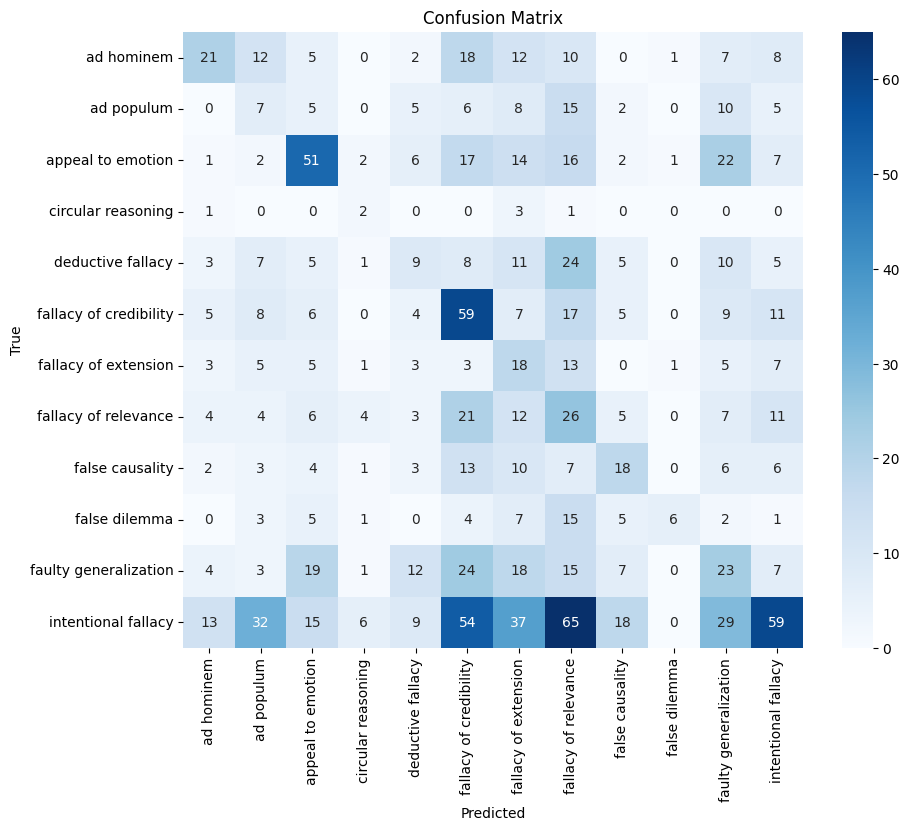

In [29]:
# Make sure the labels are strings for compatibility
y_true = logic_climate_all['logical_fallacies'].astype(str)
y_pred = logic_climate_all['normalized_fallacy_predictions'].astype(str)

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

# Precision, Recall, F1 per class
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=sorted(y_true.unique()))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=sorted(y_true.unique()), yticklabels=sorted(y_true.unique()), cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [30]:
del model, tokenizer

# Load and retrain fresh model with r = 64, lora_alpha = 64, and lora_dropout = 0.05

In [33]:
model, tokenizer = FastLanguageModel.from_pretrained(
    model_name = 'unsloth/Llama-3.1-8B-Instruct-unsloth-bnb-4bit',
    max_seq_length = max_seq_length,
    dtype = dtype,
    load_in_4bit = load_in_4bit,
    device_map="auto", # Automatically determine device mapping
)

model = FastLanguageModel.get_peft_model(
    model,
    r = 64, # Low-rank dimension, suggested 8, 16, 32, 64, 128
    target_modules = ["q_proj", "k_proj", "v_proj", "o_proj",
                      "gate_proj", "up_proj", "down_proj",], # Model parameters approximated through LoRA.
    lora_alpha = 64, # Numerator for scaling factor for delta(W)
    lora_dropout = 0.05,
    bias = "none",
    use_gradient_checkpointing = "unsloth",
    random_state = 3407,
)

==((====))==  Unsloth 2025.7.11: Fast Llama patching. Transformers: 4.54.1.
   \\   /|    NVIDIA L4. Num GPUs = 1. Max memory: 22.161 GB. Platform: Linux.
O^O/ \_/ \    Torch: 2.6.0+cu124. CUDA: 8.9. CUDA Toolkit: 12.4. Triton: 3.2.0
\        /    Bfloat16 = TRUE. FA [Xformers = None. FA2 = False]
 "-____-"     Free license: http://github.com/unslothai/unsloth
Unsloth: Fast downloading is enabled - ignore downloading bars which are red colored!


Unsloth: Dropout = 0 is supported for fast patching. You are using dropout = 0.05.
Unsloth will patch all other layers, except LoRA matrices, causing a performance hit.
Unsloth 2025.7.11 patched 32 layers with 0 QKV layers, 0 O layers and 0 MLP layers.


# Train with new prompt containing fallacy definitions to see if there is an improvement

In [34]:
fallacy_choices = "[ad hominem, ad populum, appeal to emotion, circular reasoning, deductive fallacy, fallacy of credibility, fallacy of extension, fallacy of relevance, false causality, false dilemma, faulty generalization, intentional fallacy]"

fallacy_definitions = (
    "Faulty generalization: drawing a conclusion from one or a few cases. "
    "False causality: assuming a causal link without evidence. "
    "Circular reasoning: the claim supports itself. "
    "Ad populum: assuming something is true because many believe it. "
    "False dilemma: presenting limited options when more exist. "
    "Fallacy of relevance: using unrelated information. "
    "Ad hominem: attacking the person instead of the argument. "
    "Appeal to emotion: relying on emotion over logic. "
    "Fallacy of extension: exaggerating an argument to attack it. "
    "Fallacy of credibility: appealing to authority without proof. "
    "Intentional fallacy: misrepresenting intent instead of content. "
    "Deductive fallacy: flawed logical structure."
)

# Split into prompts and targets
lfud_logic_train_df["prompt"] = lfud_logic_train_df["input"].apply(
    lambda x: (
        f"{fallacy_definitions}\n\n"
        f"Classify the logical fallacy in this sentence:\n"
        f"Sentence: {x}\n"
        f"Choose from: {fallacy_choices}\n"
        f"Answer: "
    )
)

lfud_logic_train_df["target"] = lfud_logic_train_df["output"]

lfud_logic_val_df["prompt"] = lfud_logic_val_df["input"].apply(
    lambda x: (
        f"{fallacy_definitions}\n\n"
        f"Classify the logical fallacy in this sentence:\n"
        f"Sentence: {x}\n"
        f"Choose from: {fallacy_choices}\n"
        f"Answer: "
  )
)

lfud_logic_val_df["target"] = lfud_logic_val_df["output"]

# Convert to HuggingFace Dataset
train_dataset_raw = Dataset.from_pandas(lfud_logic_train_df[["prompt", "target"]])
eval_dataset_raw = Dataset.from_pandas(lfud_logic_val_df[["prompt", "target"]])

tokenized_train_dataset = train_dataset_raw.map(
    lambda x: tokenizer(
        [p + " " + t for p, t in zip(x["prompt"], x["target"])], # Concatenate prompt and target
        truncation=True,
        padding="max_length",
        max_length=512,
    ),
    batched=True,
)
tokenized_eval_dataset = eval_dataset_raw.map(
    lambda x: tokenizer(
        [p + " " + t for p, t in zip(x["prompt"], x["target"])], # Concatenate prompt and target
        truncation=True,
        padding="max_length",
        max_length=512,
    ),
    batched=True,
)


Map:   0%|          | 0/3240 [00:00<?, ? examples/s]

Map:   0%|          | 0/360 [00:00<?, ? examples/s]

In [35]:
trainer = SFTTrainer(
    model = model,
    tokenizer = tokenizer,
    train_dataset = tokenized_train_dataset,
    eval_dataset = tokenized_eval_dataset,
    max_seq_length = max_seq_length,
    dataset_num_proc = 2,
    packing = False, # Can make training 5x faster for short sequences.
    args = TrainingArguments(
        per_device_train_batch_size = 2,
        gradient_accumulation_steps = 4,
        warmup_steps = 5,
        num_train_epochs=1,
        learning_rate = 2e-4,
        fp16 = not torch.cuda.is_bf16_supported(),
        bf16 = torch.cuda.is_bf16_supported(),
        logging_steps = 1,
        optim = "adamw_8bit",
        weight_decay = 0.01,
        lr_scheduler_type = "linear",
        seed = 3407,
        output_dir = "outputs",
        eval_strategy="steps", # Add evaluation strategy to compute metrics
        eval_steps=10, # Evaluate every 10 steps
        metric_for_best_model="eval_loss", # Specify the metric to monitor for early stopping
        load_best_model_at_end=True, # Load the best model when training ends
    ),
    callbacks=[EarlyStoppingCallback(early_stopping_patience=5)]
)

# Start the actual training
trainer_stats = trainer.train()

Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
==((====))==  Unsloth - 2x faster free finetuning | Num GPUs used = 1
   \\   /|    Num examples = 3,240 | Num Epochs = 1 | Total steps = 405
O^O/ \_/ \    Batch size per device = 2 | Gradient accumulation steps = 4
\        /    Data Parallel GPUs = 1 | Total batch size (2 x 4 x 1) = 8
 "-____-"     Trainable parameters = 167,772,160 of 8,198,033,408 (2.05% trained)


Step,Training Loss,Validation Loss
10,4.504600,4.145397
20,3.430900,3.390304
30,3.342800,3.358552
40,3.352000,3.353766
50,3.215200,3.350959
60,3.254800,3.348249
70,3.318300,3.348275
80,3.283500,3.346157
90,3.273200,3.347312
100,3.332000,3.346035


Step,Training Loss,Validation Loss
10,4.504600,4.145397
20,3.430900,3.390304
30,3.342800,3.358552
40,3.352000,3.353766
50,3.215200,3.350959
60,3.254800,3.348249
70,3.318300,3.348275
80,3.283500,3.346157
90,3.273200,3.347312
100,3.332000,3.346035


Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).


In [36]:
llama_model_checkpoint_filepath = './sample_data/llama_3.1_model_long_prompt_073125'
model.save_pretrained(llama_model_checkpoint_filepath)

In [ ]:
logic_climate_all['source_article']

,source_article
0,"In June last year , a severe heatwave claimed ..."
1,Diminishing sea ice is causing major walrus he...
2,A landmark report from the United Nations ’ sc...
3,"The report “ is quite a shock , and quite conc..."
4,The World Coal Association disputed the conclu...
...,...
1345,"So why are so many people worried , indeed , p..."
1346,"Global warming alarmism provides them , more t..."
1347,"Meanwhile , over the last decade , scientists ..."
1348,And crony capitalists have eagerly grabbed for...


In [37]:
def make_prompt(sentence):
  return (
    f"{fallacy_definitions}\n\n"
    f"Classify the logical fallacy in this sentence:\n"
    f"Sentence: {sentence}\n"
    f"Choose from: {fallacy_choices}\n"
    f"Answer: "
  )

# Ensure max_new_tokens is short so it doesn’t generate extra
pipe = pipeline(
    "text-generation",
    model=model,
    tokenizer=tokenizer,
    device_map="auto",
    max_new_tokens=15,
    return_full_text=False,
)

def classify_fallacy(text):
    prompt = make_prompt(text)
    output = pipe(prompt)[0]['generated_text'].strip()
    # Optionally clean or truncate if model generates extra
    return output.split('\n')[0].strip()  # only take first line

logic_climate_all['predicted_fallacy_v2'] = logic_climate_all['source_article'].apply(classify_fallacy)

Device set to use cuda:0


In [39]:
logic_climate_all['predicted_fallacy_v2'].unique()

array(['ad populum', 'appeal to emotion', 'faulty generalization',
       'false causality', 'ad hominem', 'fallacy of credibility',
       'deductive fallacy', 'fallacy of relevance', 'intentional fallacy',
       'fallacy of extension', 'false causalityЎыџNЎыџN', 'false dilemma',
       'fallacy of relevanceЎыџNЎыџN', 'ad populumЎыџNЎыџN',
       'intentional fallacylásil', 'fallacy of extensionlásil',
       'fallacy of credibilityЎыџNЎыџN', 'ad populumlásil',
       'faulty generalizationЎыџNЎыџN', 'false causalitylásil',
       'circular reasoning', 'intentional fallacyЎыџNЎыџN',
       'deductive fallacylásil', 'appeal to emotionılmaktadır',
       'fallacy of extension�', 'intentional fallacyılmaktadır',
       'circular reasoningЎыџNЎыџN', 'fallacy of relevancelásil',
       'false causalityılmaktadır'], dtype=object)

In [40]:
from rapidfuzz import process, fuzz
valid_labels = logic_climate_all['logical_fallacies'].unique()

def clean_text(text):
    # Remove non-letter characters (keep spaces), lowercase, and trim
    return re.sub(r'[^a-zA-Z\s]', '', text).strip().lower()

def normalize_prediction(pred, valid_labels, threshold=80):
    pred_clean = clean_text(pred)
    match, score, _ = process.extractOne(
        pred_clean, valid_labels, scorer=fuzz.token_sort_ratio
    )
    return match if score >= threshold else pred_clean

# Normalize predictions
logic_climate_all['normalized_fallacy_predictions_v2'] = logic_climate_all['predicted_fallacy_v2'].apply(
    lambda x: normalize_prediction(x, valid_labels)
)

logic_climate_all['normalized_fallacy_predictions_v2'].unique()
# logic_climate_all['normalized_fallacy_predictions'] = logic_climate_all['normalized_fallacy_predictions'].str.replace('ad populumnnldnda', 'ad populum')

array(['ad populum', 'appeal to emotion', 'faulty generalization',
       'false causality', 'ad hominem', 'fallacy of credibility',
       'deductive fallacy', 'fallacy of relevance', 'intentional fallacy',
       'fallacy of extension', 'false dilemma', 'circular reasoning',
       'false causalitylmaktadr'], dtype=object)

In [42]:
logic_climate_all['normalized_fallacy_predictions_v2'] = logic_climate_all['normalized_fallacy_predictions_v2'].str.replace('false causalitylmaktadr',  'false causality')
logic_climate_all['normalized_fallacy_predictions_v2'].unique()

array(['ad populum', 'appeal to emotion', 'faulty generalization',
       'false causality', 'ad hominem', 'fallacy of credibility',
       'deductive fallacy', 'fallacy of relevance', 'intentional fallacy',
       'fallacy of extension', 'false dilemma', 'circular reasoning'],
      dtype=object)

In [43]:
logic_climate_all['normalized_fallacy_predictions_v2'].value_counts()

,count
normalized_fallacy_predictions_v2,
intentional fallacy,235
faulty generalization,218
false causality,133
fallacy of credibility,125
ad populum,121
fallacy of relevance,112
appeal to emotion,85
ad hominem,82
deductive fallacy,76


# New result - prompt and target components

Accuracy: 0.2016

Classification Report:
                        precision    recall  f1-score   support

            ad hominem     0.2927    0.2500    0.2697        96
            ad populum     0.0496    0.0952    0.0652        63
     appeal to emotion     0.3176    0.1915    0.2389       141
    circular reasoning     0.1818    0.2857    0.2222         7
     deductive fallacy     0.1184    0.1023    0.1098        88
fallacy of credibility     0.3040    0.2901    0.2969       131
  fallacy of extension     0.1143    0.1250    0.1194        64
  fallacy of relevance     0.1250    0.1359    0.1302       103
       false causality     0.1429    0.2603    0.1845        73
         false dilemma     0.1765    0.0612    0.0909        49
 faulty generalization     0.1376    0.2256    0.1709       133
   intentional fallacy     0.3362    0.2344    0.2762       337

              accuracy                         0.2016      1285
             macro avg     0.1914    0.1881    0.1812      12

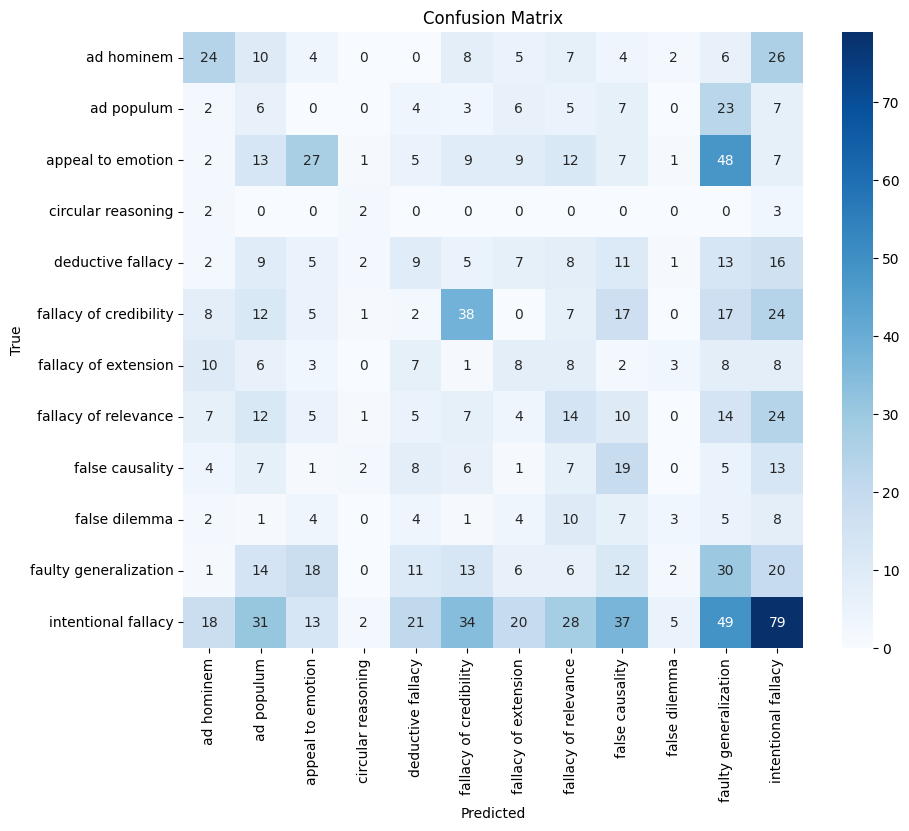

In [44]:
# Make sure the labels are strings for compatibility
y_true = logic_climate_all['logical_fallacies'].astype(str)
y_pred = logic_climate_all['normalized_fallacy_predictions_v2'].astype(str)

# Accuracy
acc = accuracy_score(y_true, y_pred)
print(f"Accuracy: {acc:.4f}")

# Precision, Recall, F1 per class
print("\nClassification Report:")
print(classification_report(y_true, y_pred, digits=4))

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred, labels=sorted(y_true.unique()))
plt.figure(figsize=(10,8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=sorted(y_true.unique()), yticklabels=sorted(y_true.unique()), cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()